# Cluster Analysis using Unsupervised Learning
****


There is a big mall in a specific city that keeps information of its customers who subscribe to a membership card. In the membetrship card they provide following information : gender, age and annula income. The customers use this membership card to make all the purchases in the mall, so tha mall has the purchase history of all subscribed members and according to that they compute the Spending score of all customers. We have to segment these customers based on the details given. 


First, we import the neccesary modules

In [333]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')

%matplotlib inline


Now, we load the dataset and check the data for any missing values


In [327]:
customer_info = pd.read_csv("Mall_Customers.csv")
customer_info.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [328]:
customer_info.shape

(200, 5)

In [329]:
customer_info.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [330]:
customer_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
CustomerID                200 non-null int64
Gender                    200 non-null object
Age                       200 non-null int64
Annual Income (k$)        200 non-null int64
Spending Score (1-100)    200 non-null int64
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [334]:
print(customer_info.isnull().any().any())

False


After going through our data, we found no missing values. This is good because now we can directly use this data for our analysis.

But before that, we need to remove Customer ID as it will be unique for each customer and it will not provide any help.

In [332]:
customer_info.drop(["CustomerID"], axis=1, inplace=True)
customer_info.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


Now it's time to visualize our data to see if there are any relationship between any of the columns. We can also get interesting insights from these visualizations.


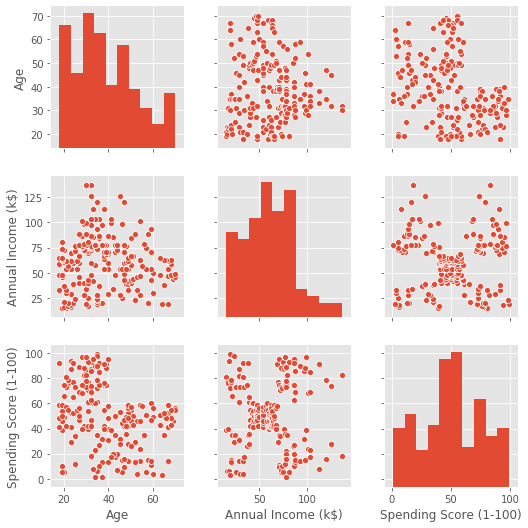

In [287]:
sns.pairplot(customer_info)

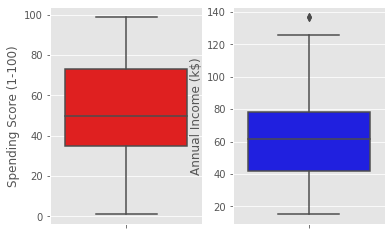

In [288]:
plt.subplot(1,2,1)
sns.boxplot(y=customer_info["Spending Score (1-100)"], color="red")
plt.subplot(1,2,2)
sns.boxplot(y=customer_info["Annual Income (k$)"], color="blue")


([<matplotlib.patches.Wedge at 0x20dc38ef7b8>,
 [Text(-0.20611945413751356, 1.080515974257694, 'Male'),
  Text(0.2248575863318331, -1.1787446991902115, 'Female')])

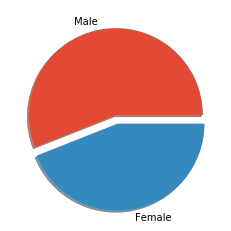

In [289]:
labels=["Male", "Female"]
size= customer_info["Gender"].value_counts()
explode=[0,0.1]
plt.pie(size,labels = labels, explode = explode, shadow = True)

There is a gender column which has values in form of text. Our model can only understand numeric values. So we need to encode Gender in such a way that it gets converted to number without losing it's actual meaning. For this, we will use LabelEncoder to convert Male and Female into 1 and 0 respecrively.


In [335]:
le = LabelEncoder()
customer_info["Gender"] = le.fit_transform(customer_info["Gender"])
customer_info.head(10)

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40
5,0,22,17,76
6,0,35,18,6
7,0,23,18,94
8,1,64,19,3
9,0,30,19,72


We can see 'Male' is given the value of 1 while 'Female' has been given a value of 0. So it would make sense if we rename the column as 'Is Male'. Then if we get a value of 1, it means the person is male, else female. 

In [336]:
customer_info=customer_info.rename(columns={"Gender":"Is Male"})
customer_info.head()

,Is Male,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40




There is one final thing we need to do before we use unsupervised learning to predict clusters. We have to normalise the features because each individual column has their own scale. Thus to properly compare and form a relation between the columns, we need to bring them on a common scale. To do this, we use normalize function.



In [337]:
col_names = ['Age', "Annual Income (k$)", "Spending Score (1-100)"]
features= customer_info[col_names]
normalized_features=normalize(features)

In [338]:
normalized_customer_info=customer_info.copy()
normalized_customer_info[col_names]=normalized_features
normalized_customer_info.head()

,Is Male,Age,Annual Income (k$),Spending Score (1-100)
0,1,0.413925,0.326783,0.849635
1,1,0.247025,0.176446,0.952809
2,0,0.760286,0.608229,0.228086
3,0,0.280697,0.195267,0.939723
4,0,0.580683,0.318439,0.749269


Now that we have normalized our data, we can use KMeans to find the appropriate number of clusters in the data. Instead of using distance, KMeans has inertia which determines the quality of each cluster. The lower the inertia, the better. So we plot a graph of inertia vs number of clusters to see how many clusters will suit our data. 

But the inertia will decrease as the number of cluster increases, that will always be the case. So, we find a value of cluster after which the change of inertia will not be enough to consider increasing nomber of clusters. This point is called as elbow point and it is can be seen as a sharp turn in the graph. 

In the graph given below, the curve is smooth so it's a bit hard to point, but we can say that the elbow point is somewhere around 4 or 5.

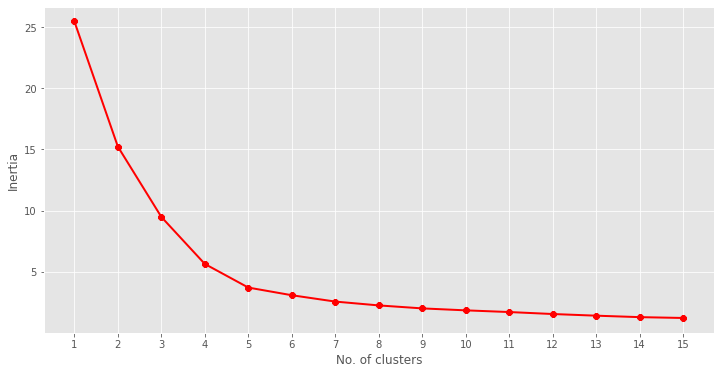

In [294]:
X=normalized_customer_info.iloc[:,1:4]
inertia=[]
for i in range(1,16):
    kmeans=KMeans(n_clusters=i, init='k-means++', random_state=420)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.plot(range(1,16), inertia, linewidth=2, color="red", marker ="8")
plt.xlabel("No. of clusters")
plt.xticks(np.arange(1,16,1))
plt.ylabel("Inertia")
plt.show()

We can also use hierarchical analysis to get number of clusters. The way it works basically is that it takes individual point and joins them into a cluster after a particular distance. So if we were to look at that from top to bottom, we can get number of clusters we need to differetiate among points from a certain distance. Here I chose 5 number of clusters.

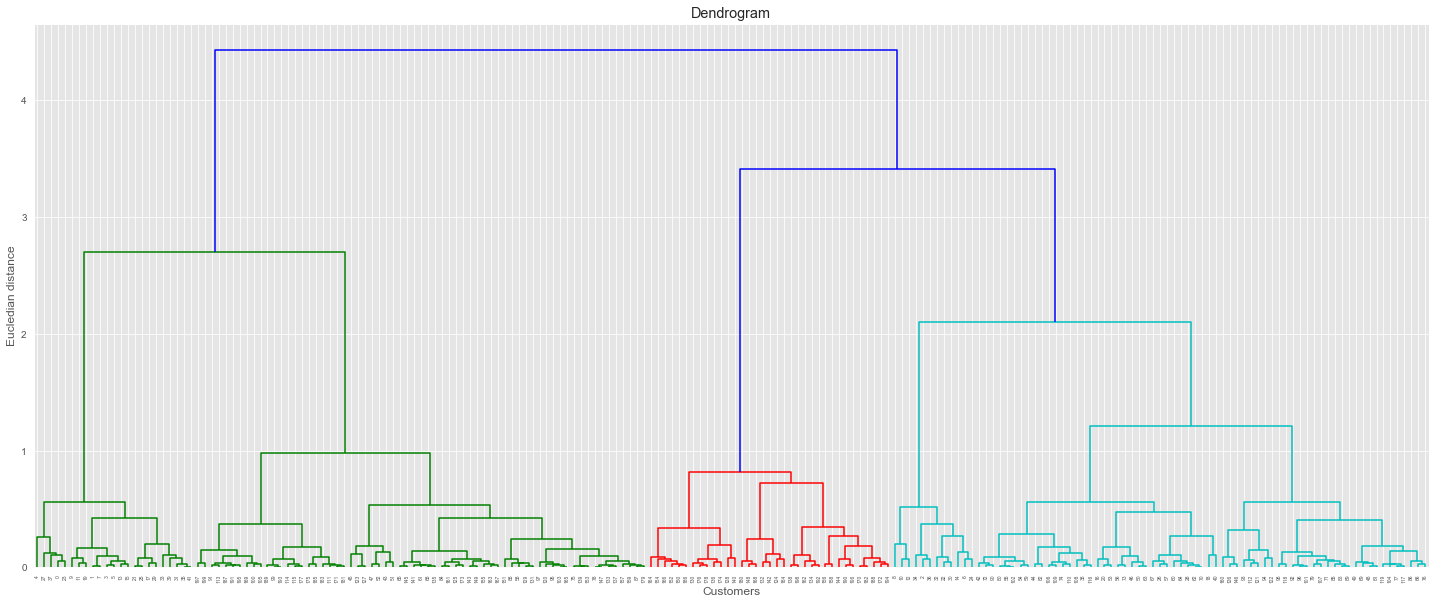

In [339]:
fig = plt.figure(figsize=(25, 10))
dendrogram=sch.dendrogram(sch.linkage(normalized_customer_info.iloc[:,1:],method='ward'))
plt.title("Dendrogram")
plt.xlabel("Customers")
plt.ylabel("Eucledian distance")
plt.show()

Now we can donfirm that if we use Age, Annual Income and Spending Score as our features, we can classify our customers into five clusters. Now what's left is to implement KMeans to divide the functions into five different categories and see our result

In [344]:
kmeans= KMeans(n_clusters=5)
clusters=kmeans.fit_predict(X)
customer_info["label"]=clusters
customer_info.head()

,Is Male,Age,Annual Income (k$),Spending Score (1-100),label
0,1,19,15,39,2
1,1,21,15,81,2
2,0,20,16,6,3
3,0,23,16,77,2
4,0,31,17,40,2


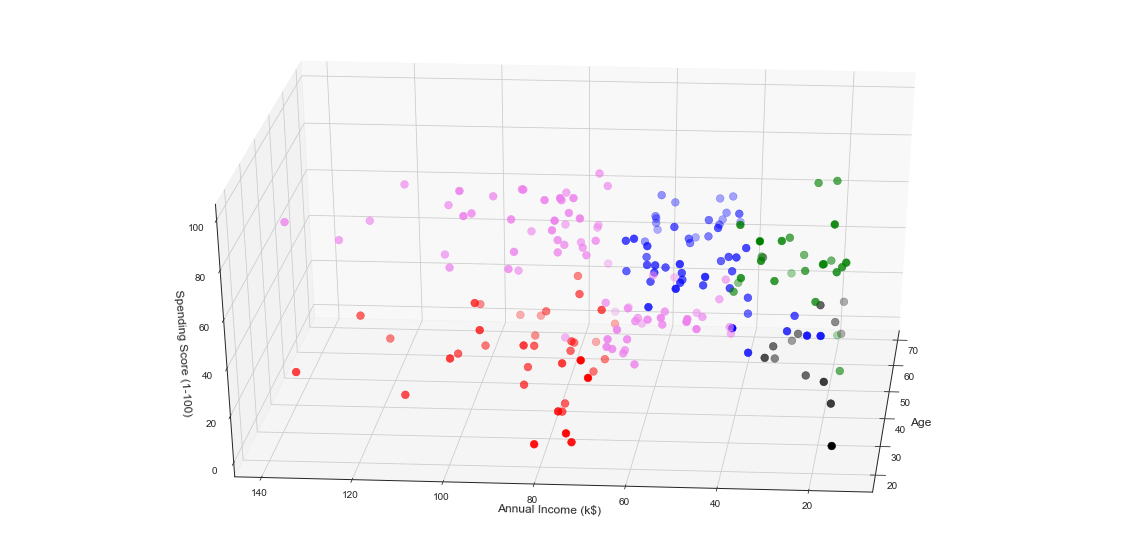

In [346]:
sns.set_style("white")
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(customer_info.Age[customer_info.label == 0], customer_info["Annual Income (k$)"][customer_info.label == 0], customer_info["Spending Score (1-100)"][customer_info.label == 0], c='blue', s=60)
ax.scatter(customer_info.Age[customer_info.label == 1], customer_info["Annual Income (k$)"][customer_info.label == 1], customer_info["Spending Score (1-100)"][customer_info.label == 1], c='red', s=60)
ax.scatter(customer_info.Age[customer_info.label == 2], customer_info["Annual Income (k$)"][customer_info.label == 2], customer_info["Spending Score (1-100)"][customer_info.label == 2], c='green', s=60)
ax.scatter(customer_info.Age[customer_info.label == 3], customer_info["Annual Income (k$)"][customer_info.label == 3], customer_info["Spending Score (1-100)"][customer_info.label == 3], c='black', s=60)
ax.scatter(customer_info.Age[customer_info.label == 4], customer_info["Annual Income (k$)"][customer_info.label == 4], customer_info["Spending Score (1-100)"][customer_info.label == 4], c='violet', s=60)
ax.view_init(30, 185)
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
ax.set_zlabel('Spending Score (1-100)')
plt.show()

Now we have classified our customers into five different categories. We can use this for our benefit. 

